# L3: Measuring Cache Effectiveness

In this lab, you’ll learn how to evaluate your cache using metrics like hit rate, precision, recall, and latency to understand its real impact.


In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

## Setup Environment

In [2]:
# %load_ext autoreload
# %autoreload 2

import pandas as pd
import numpy as np
import time

from tqdm.auto import tqdm

from cache.evals import CacheEvaluator
from cache.faq_data_container import FAQDataContainer
from cache.wrapper import SemanticCacheWrapper
from cache.config import config, load_openai_key

print("📦 Libraries imported successfully")

📦 Libraries imported successfully


## Load Data and Recreate Cache

In [3]:
data_container = FAQDataContainer()
faq_df, test_df = data_container.faq_df, data_container.test_df

test_queries = test_df["question"].tolist()

Loaded 8 FAQ entries
Loaded 80 test queries


In [4]:
# Initialize semantic cache wrapper from config
cache_wrapper = SemanticCacheWrapper.from_config(config)

✅ Redis is running and accessible!
21:09:56 sentence_transformers.SentenceTransformer INFO   Use pytorch device_name: cpu
21:09:56 sentence_transformers.SentenceTransformer INFO   Load pretrained SentenceTransformer: redis/langcache-embed-v1
21:10:11 redisvl.index.index INFO   Index already exists, not overwriting.


## Evaluating cache quality

In [5]:
# Cache hydration via wrapper helper
cache_wrapper.hydrate_from_df(faq_df)

cache_wrapper.check(faq_df["question"].iloc[0])

(Query: 'How do I get a refund?', Matches: ['How do I get a refund?'])

In [6]:
test_queries[:4]

["What's the process for getting my money back?",
 'How can I request a refund for my purchase?',
 'What steps do I follow to return an item for money back?',
 "What's your refund policy for digital products?"]

In [7]:
cache_results = cache_wrapper.check_many(test_queries)
cache_results[:4]

[(Query: 'What's the process for getting my money back?', Matches: ['How do I get a refund?']),
 (Query: 'How can I request a refund for my purchase?', Matches: ['How do I get a refund?']),
 (Query: 'What steps do I follow to return an item for money back?', Matches: ['How do I get a refund?']),
 (Query: 'What's your refund policy for digital products?', Matches: [])]

In [8]:
evaluator = CacheEvaluator(
    true_labels=data_container.label_cache_hits(cache_results),
    cache_results=cache_results,
)
evaluator.report_metrics()

Column
    [0] Markdown(str)
    [1] Row
        [0] DataFrame(DataFrame, width=200)
        [1] DataFrame(Styler)

In [9]:
[[tn, fp], [fn, tp]] = evaluator.get_metrics()["confusion_mask"]

In [10]:
tn[:9]

array([False, False, False,  True,  True, False,  True,  True,  True])

In [11]:
evaluator.matches_df()[fp]

,query,match,distance,true_label
5,Can I get a refund if I changed my mind?,How do I get a refund?,0.294378,False
24,Can I change my order after it's been placed?,Can I change my delivery address?,0.286985,False
53,How do I upgrade my subscription plan?,How do I cancel my subscription?,0.250155,False
55,Can I pause my subscription temporarily?,How do I cancel my subscription?,0.277127,False
75,Can I schedule a specific delivery time?,Can I change my delivery address?,0.286493,False


## Evaluating cache latency

In [12]:
def simulate_llm_call(prompt):
    time.sleep(np.random.uniform(0.2, 0.5))
    return f"LLM response to {prompt}"

In [13]:
from cache.evals import PerfEval

perf_eval = PerfEval()

with perf_eval:
    for query in tqdm(test_queries):
        cache_wrapper.check(query)
        perf_eval.tick("cache_hit")
        perf_eval.start()
        simulate_llm_call(query)
        perf_eval.tick("llm_call")

metrics = perf_eval.get_metrics(labels=["cache_hit", "llm_call"])

100%|██████████| 80/80 [00:31<00:00,  2.51it/s]


In [14]:
metrics["by_label"]

{'cache_hit': {'count': 80,
  'average_latency': 24.37376379966736,
  'p50': 25.19381046295166,
  'p90': 35.878562927246094,
  'p95': 37.37721443176269,
  'p99': 50.95566987991323,
  'average_throughput': 41027.72178393095},
 'llm_call': {'count': 80,
  'average_latency': 373.35575222969055,
  'p50': 377.56216526031494,
  'p90': 492.855978012085,
  'p95': 503.32241058349615,
  'p99': 507.174174785614,
  'average_throughput': 2678.410588367725}}

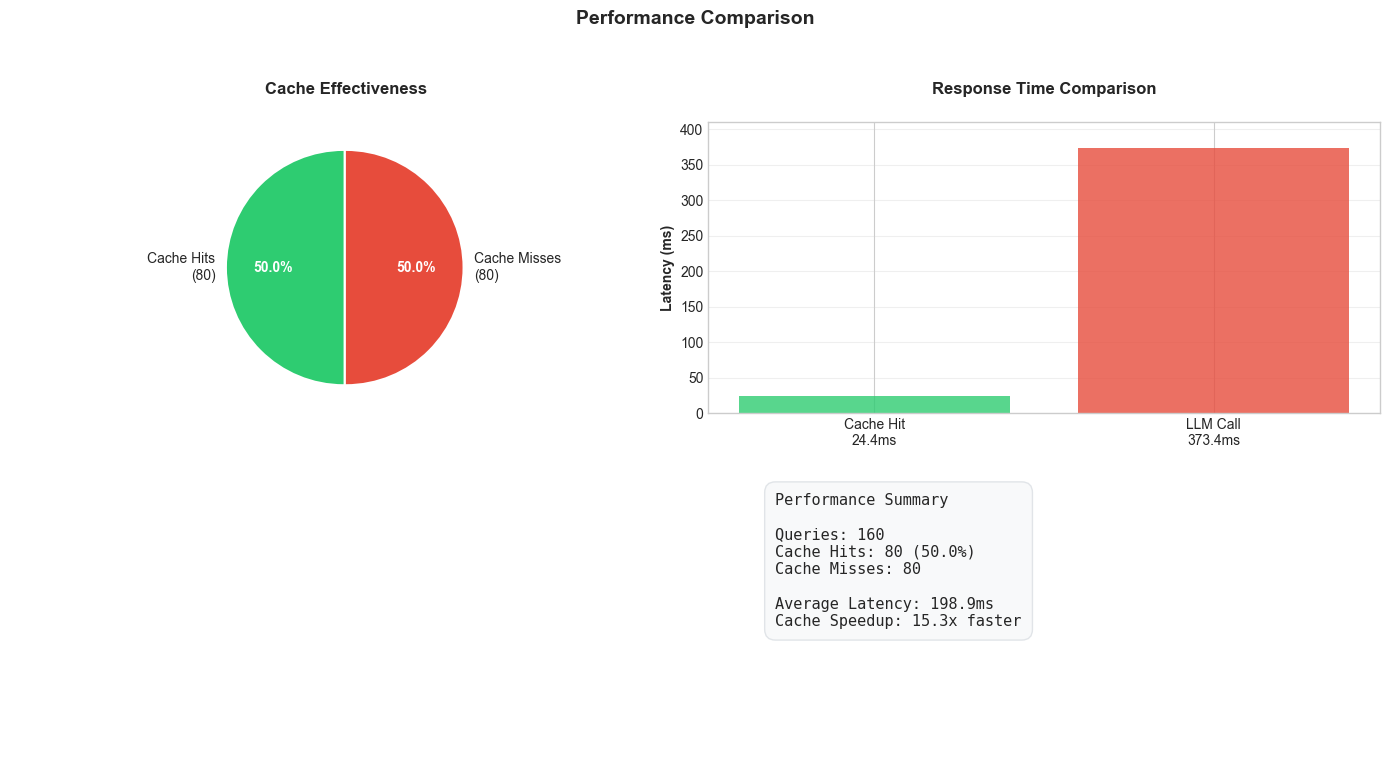

In [15]:
perf_eval.plot(
    title="Performance Comparison", show_cost_analysis=False
)

<b>Note:</b> In the above experiment we measure the latency of the cache response and a mocked latency of an LLM call. The mocked LLM call is a dummy function that sleeps for a random amount of time. The randomness in the results mainly comes from the randomness we introduced to mock the LLM. The results show us what we can typically see in practice.

In [16]:
llm_latency = metrics["by_label"]["llm_call"]["average_latency"]
cache_latency = metrics["by_label"]["cache_hit"]["average_latency"]

cache_hit_rate = 0.3
cached_llm_latency = llm_latency * (1 - cache_hit_rate) + cache_latency * cache_hit_rate
cached_llm_drop_in_latency = (llm_latency - cached_llm_latency) / llm_latency
cached_llm_speedup = llm_latency / cached_llm_latency
print(f"Overall latency drop of an LLM app: {int(cached_llm_drop_in_latency * 100)}%")
print(f"Overall speedup of an LLM app {cached_llm_speedup:.2f}x")

Overall latency drop of an LLM app: 28%
Overall speedup of an LLM app 1.39x


## LLM-as-a-Judge for cache quality evaluation

In [17]:
cache_wrapper.hydrate_from_df(faq_df)

# we set the distance to obtain even bad matches and evaluate if they are true negatives
full_retrieval_nearest_neighbors = cache_wrapper.check_many(
    test_queries, distance_threshold=1
)
full_retrieval_matches = [h.matches[0].prompt for h in full_retrieval_nearest_neighbors]
full_retrieval_matches[:4]

['How do I get a refund?',
 'How do I get a refund?',
 'How do I get a refund?',
 'How do I get a refund?']

In [18]:
load_openai_key()

> OpenAI API key is already loaded in the environment


In [19]:
from cache.llm_evaluator import LLMEvaluator

evaluator = LLMEvaluator.construct_with_ollama()

In [20]:
llm_similarity_results = evaluator.predict(
    dataset=zip(test_queries, full_retrieval_matches),
    batch_size=5,
)

  0%|          | 0/16 [00:00<?, ?it/s]

21:11:13 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:14 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:16 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:17 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:19 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


  6%|▋         | 1/16 [00:19<04:46, 19.13s/it]

21:11:21 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:22 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:24 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:26 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:28 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 12%|█▎        | 2/16 [00:28<03:08, 13.47s/it]

21:11:30 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:32 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:35 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:36 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:38 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 19%|█▉        | 3/16 [00:39<02:36, 12.06s/it]

21:11:41 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:43 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:45 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:47 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:49 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 25%|██▌       | 4/16 [00:48<02:14, 11.24s/it]

21:11:51 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:52 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:55 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:57 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:11:59 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 31%|███▏      | 5/16 [00:59<02:01, 11.07s/it]

21:12:01 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:03 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:05 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:07 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:10 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 38%|███▊      | 6/16 [01:10<01:48, 10.89s/it]

21:12:12 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:14 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:16 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:18 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:20 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 44%|████▍     | 7/16 [01:20<01:35, 10.59s/it]

21:12:22 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:24 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:26 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:28 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:30 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 50%|█████     | 8/16 [01:31<01:25, 10.64s/it]

21:12:33 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:35 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:37 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:39 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:42 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 56%|█████▋    | 9/16 [01:42<01:16, 10.93s/it]

21:12:44 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:46 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:48 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:49 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:51 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 62%|██████▎   | 10/16 [01:51<01:02, 10.35s/it]

21:12:53 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:55 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:57 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:12:58 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:00 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 69%|██████▉   | 11/16 [02:01<00:51, 10.27s/it]

21:13:03 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:05 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:07 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:09 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:10 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 75%|███████▌  | 12/16 [02:10<00:39,  9.90s/it]

21:13:12 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:14 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:16 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:17 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:19 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 81%|████████▏ | 13/16 [02:19<00:28,  9.66s/it]

21:13:22 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:26 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:30 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:33 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:35 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 88%|████████▊ | 14/16 [02:37<00:24, 12.01s/it]

21:13:40 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:43 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:45 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:48 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:50 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


 94%|█████████▍| 15/16 [02:51<00:12, 12.50s/it]

21:13:53 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:13:58 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:14:02 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:14:05 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"
21:14:08 httpx INFO   HTTP Request: POST http://127.0.0.1:11434/api/chat "HTTP/1.1 200 OK"


100%|██████████| 16/16 [03:09<00:00, 11.87s/it]


In [21]:
llm_similarity_results.df.head()

,reason,is_similar
0,The two sentences mean the same thing because ...,True
1,The two sentences mean the same thing. They bo...,True
2,The two sentences mean the same thing. Both se...,True
3,The two sentences describe different refund po...,False
4,The two sentences mean the same thing. They bo...,True


In [22]:
# When evaluation is based on full retrieval we should use this constructor
evaluator = CacheEvaluator.from_full_retrieval(
    true_labels=llm_similarity_results.df["is_similar"].values,
    cache_results=cache_wrapper.check_many(test_queries),
)
evaluator.report_metrics()

Column
    [0] Markdown(str)
    [1] Row
        [0] DataFrame(DataFrame, width=200)
        [1] DataFrame(Styler)

In [23]:
cache_wrapper.cache.clear()